In [1]:
# load libs 

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from typing import Union 
from pathlib import Path
from torch import device, cuda, hub
from torch import no_grad
from tqdm import tqdm

from timm.data import resolve_model_data_config, create_transform
import os
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/home/afroehli/miniconda3/envs/dinov2Pre/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load general list for wnid to index mapping: Index(wnid) -> pos. in list

class_to_index_mapping = []

with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
    class_index_reader = csv.reader(class_index_table, delimiter=';')
    for inet_class, _ in class_index_reader: 
        class_to_index_mapping.append(inet_class)


In [3]:
# Dataset where classes are defined by directories + exclude directories from loading by instantiation 

class CustomizedImageFolder(ImageFolder): 

    def __init__(self, not_processed_imagenet_classes = None, root = None, transform = None):
        self.not_processed_imagenet_classes = not_processed_imagenet_classes 
        super().__init__(root = root, transform = transform)

    def find_classes(self, directory: Union[str, Path]) -> tuple[list[str], dict[str, int]]:

        class_list = []
        class_index_dict = dict()
    
        with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:

            class_index_reader = csv.reader(class_index_table, delimiter=';')
            for table_row in class_index_reader:
                class_wnid = table_row[0]
                class_index = table_row[1]

                if class_wnid in self.not_processed_imagenet_classes:
                    class_list.append(class_wnid)
                    class_index_dict[class_wnid] = class_index

        return class_list, class_index_dict

In [4]:
# Dataset where classes are defined by directories + exclude directories from loading by instantiation 

class CustomizedImageFolderForImagenetV2(ImageFolder): 

    def __init__(self, not_processed_imagenet_classes = None, root = None, transform = None):
        self.not_processed_imagenet_classes = not_processed_imagenet_classes 
        super().__init__(root = root, transform = transform)

    def find_classes(self, directory: Union[str, Path]) -> tuple[list[str], dict[str, int]]:

        class_list = []
        class_index_dict = dict()
    
        with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
            with open('/home/afroehli/datasets/imagenet_v2_label_transform/imagenet_1k_label_order.txt', 'r') as label_order_file:
                inet_1k_labels = label_order_file.readlines()
                inet_1k_labels = [label_order_line.split()[0] for label_order_line in inet_1k_labels]

                class_index_reader = csv.reader(class_index_table, delimiter=';')
                for table_row in class_index_reader:
                    class_wnid = table_row[0]
                    class_index = table_row[1]

                    inet_1k_label_pos = inet_1k_labels.index(class_wnid)
                    if class_wnid in self.not_processed_imagenet_classes:
                        class_list.append(class_wnid)
                        class_index_dict[str(inet_1k_label_pos)] = class_index

        return class_list, class_index_dict

In [7]:
# prepare datasets and dataloaders 

timm_model = 'vit_small_patch14_dinov2'
timm_model_conf = resolve_model_data_config(timm_model)
timm_model_conf['input_size'] = (3, 518, 518)

timm_transform = create_transform(**timm_model_conf, is_training=False)

print(f'Following transform will be applied: {timm_transform}')
print(timm_model_conf)

transform = timm_transform 

# old transform
# transform = transforms.Compose([transforms.Resize((518, 518)),
#                                 transforms.ToTensor()])

with open('/home/afroehli/datasets/imagenet_v2_label_transform/imagenet_1k_label_order.txt', 'r') as label_order_file:
    inet_1k_labels = label_order_file.readlines()
    inet_1k_labels = [label_order_line.split()[0] for label_order_line in inet_1k_labels]

inet_r_path = Path('/home/afroehli/datasets/ImagenetR/images')
inet_r_path.resolve()
inet_r_labels = os.listdir(inet_r_path)

# datasets 

inet_v2_70 = CustomizedImageFolderForImagenetV2(not_processed_imagenet_classes=inet_1k_labels,
                                                root='/home/afroehli/datasets/ImagenetV2/imagenetv2-threshold0.7-format-val', transform=transform)
inet_v2_mf = CustomizedImageFolderForImagenetV2(not_processed_imagenet_classes=inet_1k_labels,
                                                root='/home/afroehli/datasets/ImagenetV2/imagenetv2-matched-frequency-format-val', transform=transform)
inet_v2_top = CustomizedImageFolderForImagenetV2(not_processed_imagenet_classes=inet_1k_labels,
                                                 root='/home/afroehli/datasets/ImagenetV2/imagenetv2-top-images-format-val', transform=transform)

inet_1k_val_resized = CustomizedImageFolder(not_processed_imagenet_classes=inet_1k_labels, 
                                            root='/home/afroehli/datasets/ImageNet1k/imagenet1k/ILSVRC/Data/CLS-LOC/val_sorted', transform=transform)

inet_1k_train = CustomizedImageFolder(not_processed_imagenet_classes=inet_1k_labels, root='/home/afroehli/datasets/ImageNet1k/imagenet1k/ILSVRC/Data/CLS-LOC/train', transform=transform)


inet_r = CustomizedImageFolder(not_processed_imagenet_classes=inet_r_labels, root=inet_r_path, transform=transform)

# dataloader 

inet_1k_val_loader = DataLoader(dataset=inet_1k_val_resized, shuffle=False, batch_size=128, num_workers=8, pin_memory=True)

inet_v2_70_loader = DataLoader(dataset=inet_v2_70, shuffle=False, batch_size=128, num_workers=8, pin_memory=True)

inet_v2_mf_loader = DataLoader(dataset=inet_v2_mf, shuffle=False, batch_size=128, num_workers=8, pin_memory=True)

inet_v2_top_loader = DataLoader(dataset=inet_v2_top, shuffle=False, batch_size=128, num_workers=8, pin_memory=True)

inet_1k_train_loader = DataLoader(dataset=inet_1k_train, shuffle=False, batch_size=128, num_workers=8, pin_memory=True)

inet_r_loader = DataLoader(dataset=inet_r, shuffle=False, batch_size=128, num_workers=8, pin_memory=True)

print(f'inet-1k: {len(inet_1k_val_resized)}')
print(f'inet_v2_70: {len(inet_v2_70)}')
print(f'inet_1k_train: {len(inet_1k_train)}')
print(f'inet_r: {len(inet_r)}')


Following transform will be applied: Compose(
    Resize(size=592, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(518, 518))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
{'input_size': (3, 518, 518), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
inet-1k: 50000
inet_v2_70: 10000
inet_1k_train: 1281167
inet_r: 30000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


682


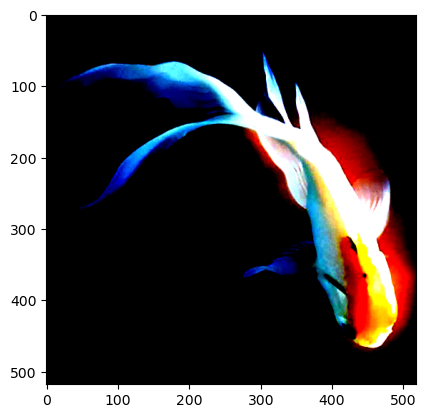

In [21]:
print(inet_1k_val_resized[50][1])

img_tensor = inet_1k_val_resized[50][0].detach().numpy()
img_array = np.squeeze(img_tensor)
img_array = np.transpose(img_array, (1, 2, 0))
plt.imshow(img_array)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


682
Wordnet: n01443537


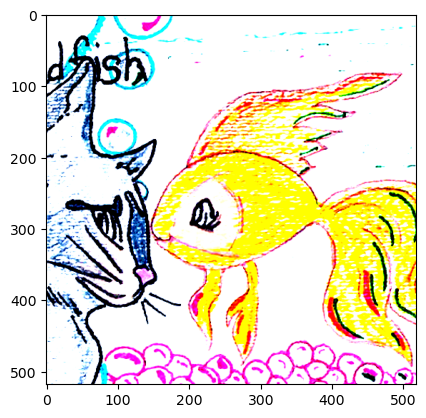

In [23]:
print(inet_r[51][1])
with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
    csv_reader = csv.reader(class_index_table, delimiter=';')
    for wnid, index in csv_reader:
        # print(f'Wordnet *{wnid}*, Index *{index}*')
        if int(index) == 682:
            print(f'Wordnet: {wnid}')

img_tensor = inet_r[51][0].detach().numpy()
img_array = np.squeeze(img_tensor)
img_array = np.transpose(img_array, (1, 2, 0))
plt.imshow(img_array)
plt.show()


In [24]:
# define model to be used 

device = device('cuda' if cuda.is_available() else 'cpu')
print(f'Device used: {device}')

vision_transformer = hub.load('facebookresearch/dinov2', 'dinov2_vits14')
vision_transformer.eval()
vision_transformer.to(device)

Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [25]:
# compute new embeddings 

inet_1k_val_loader_tuple = (inet_1k_val_loader, '/home/afroehli/coding/model_results/dinov2_vits14/inet_1k_val_timm_trans.pkl')
inet_1k_train_loader_tuple = (inet_1k_train_loader, '/home/afroehli/coding/model_results/dinov2_vits14/inet_1k_train_timm_trans.pkl')
inet_v2_70_loader_tuple = (inet_v2_70_loader, '/home/afroehli/coding/model_results/dinov2_vits14/inet_v2_70_timm_trans.pkl')
inet_v2_mf_loader_tuple = (inet_v2_mf_loader, '/home/afroehli/coding/model_results/dinov2_vits14/inet_v2_mf_timm_trans.pkl')
inet_v2_top_loader_tuple = (inet_v2_top_loader, '/home/afroehli/coding/model_results/dinov2_vits14/inet_v2_top_timm_trans.pkl')
inet_r_loader_tuple = (inet_r_loader, '/home/afroehli/coding/model_results/dinov2_vits14/inet_r_timm_trans.pkl')

dataloaders = [inet_r_loader_tuple]

with no_grad():

    for loader, str_path in dataloaders:
            
        model_results = dict()

        print(f'Next calculate results for dataset: {str_path.split('/')[-1].removesuffix('.pkl')}')

        for samples, sample_indices in (pbar := tqdm(loader, ncols=100)):

            samples_transferred = samples.to(device)
            model_out = vision_transformer(samples_transferred)

            wnid_per_sample = [class_to_index_mapping[int(sample_index)] for sample_index in sample_indices]

            model_out_converted = [sample_out.cpu().detach().numpy() for sample_out in model_out]

            for n, sample_out_conv in enumerate(model_out_converted):
                sample_item_wnid = wnid_per_sample[n]
                try: 
                    model_results[sample_item_wnid].append(sample_out_conv)
                except KeyError:
                    model_results[sample_item_wnid] = []
                    model_results[sample_item_wnid].append(sample_out_conv)
                    

        with open(str_path, 'wb') as pkl_file:
            pickle.dump(model_results, pkl_file, pickle.HIGHEST_PROTOCOL)

Next calculate results for dataset: inet_r_timm_trans


100%|█████████████████████████████████████████████████████████████| 235/235 [08:07<00:00,  2.08s/it]


In [10]:
# check if all embeddings have been computed 

with open('/home/afroehli/datasets/imagenet_v2_label_transform/imagenet_1k_label_order.txt', 'r') as label_order_file:
    inet_1k_labels = label_order_file.readlines()
    inet_1k_labels = [label_order_line.split()[0] for label_order_line in inet_1k_labels]
    
with open('/home/afroehli/coding/model_results/dinov2_vits14/inet_1k_train_timm_trans.pkl', 'rb') as pkl_file:
    inet_1k_train_model_results = pickle.load(pkl_file)

incomplete_classes = 0
for wnid in inet_1k_labels:
    expec_embeds = len(os.listdir(f'/home/afroehli/datasets/ImageNet1k/imagenet1k/ILSVRC/Data/CLS-LOC/train/{wnid}'))

    if expec_embeds != len(inet_1k_train_model_results[wnid]):
        incomplete_classes += 1 

print(f'Number of incomplete classes: {incomplete_classes}')


Number of incomplete classes: 0
